# **Lifetimes**

## Setup

In [221]:
import pandas as pd
import lifetimes
import datetime
import numpy as np
# Charting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [60]:
raw_df = pd.read_pickle('df.pickle')

In [232]:
def clean(df):
    df = df[df['Fecha'] >= (max(df['Fecha']) - datetime.timedelta(455))]
    df = df[df['Valor FOB'] > 0]

    df = df[[
        'Cliente', 
        'Fecha',
        'Valor FOB'
        ]]

    df['T'] = max(df['Fecha']) - df['Fecha']
    df['T'] = df['T'].dt.days

    df['log_MV'] = np.log10(df['Valor FOB'])
    
    return df
df = clean(raw_df)
df.head()

,Cliente,Fecha,Valor FOB,T,log_MV
0,BANCO MULTIPLE BHD LEÓN S.A.,2022-01-31,13198.0100,0,4.120508
2,CONSUMIDOR FINAL FISICO,2022-01-20,579200.0000,11,5.762829
1,ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,2022-01-20,28862.6944,11,4.460337
3,LARC CONSULTORIA Y REDISENO ORGANIZACIONAL SRL,2022-01-19,6019.5200,12,3.779562
4,BANCO POPULAR DOMINICANO,2022-01-14,90011.4243,17,4.954298


## Transform data as RFM

### Custom transform

In [241]:
def get_rfm(df):
    def get_frequecy(df):
        df = df.copy().groupby(by=['Cliente']).count()['Fecha']-1
        df.name = 'frequency'
        df = df.sort_values(ascending=False)
        return df

    def get_recency(df):
        df = df.copy().groupby(by=['Cliente']).min()['T']
        df.name = 'recency'
        df = df.sort_values(ascending=False)
        return df

    def get_T(df):
        df = df.copy().groupby(by=['Cliente']).max()['T']
        df.name = 'T'
        df = df.sort_values(ascending=False)
        return df

    def get_Monetary_Value(df):
        df = df.copy().groupby(by=['Cliente']).mean()['Valor FOB']
        df.name = 'Monetary_Value'
        df = df.sort_values(ascending=False)
        return df

    def get_log_Monetary_Value(df):
        df = df.copy().groupby(by=['Cliente']).mean()['log_MV']
        df.name = 'log_MV'
        df = df.sort_values(ascending=False)
        return df

    freq = get_frequecy(df)
    rec = get_recency(df)
    T = get_T(df)
    mon = get_Monetary_Value(df)
    log = get_log_Monetary_Value(df)

    rfm = pd.concat([freq,rec,T, mon, log], axis=1)
    return rfm

rfm = get_rfm(df)
rfm

,frequency,recency,T,Monetary_Value,log_MV
Cliente,,,,,
BANCO POPULAR DOMINICANO,30,17,454,3.317455e+05,5.248427
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,29,11,454,6.054839e+05,5.196117
CONSUMIDOR FINAL FISICO,24,11,439,5.971923e+05,4.597262
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,10,20,298,1.859375e+06,5.482349
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,9,55,439,4.126602e+05,5.128952
...,...,...,...,...,...
GRUPO SANTOS MOREL GSM SRL,0,48,48,9.597606e+03,3.982163
GRUPO A M SRL,0,90,90,5.940900e+03,3.773852
GREEN MAN DESIGNS,0,47,47,5.948977e+03,3.774442


In [251]:
# plot_df = np.log10(rfm[rfm.frequency > 0].frequency)
plot_df = np.sqrt(rfm)

fig = px.histogram(plot_df, x="frequency")


fig.update_layout(
    title_text='Cantidad de clientes por Ventas', # title of plot
    xaxis_title_text='Pesos', # xaxis label
    yaxis_title_text='Cantidad', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates)
    )

fig.show()
# histogram_log_MV(rfm)
# plo

In [235]:
# Frequency Recency
def histogram_recency(df):
    fig = px.histogram(df, x="recency")
    
    fig.update_layout(
        title_text='Cantidad de clientes por dias desde ultima venta', # title of plot
        xaxis_title_text='Dias', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_recency(rfm)

In [236]:
# Frequency T
def histogram_T(df):
    fig = px.histogram(df, x="T")
    
    fig.update_layout(
        title_text='Cantidad de clientes por Edad', # title of plot
        xaxis_title_text='Edad en Dias', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_T(rfm)

In [237]:
# Frequency Monetary Value
def histogram_Monetary_Value(df):
    df = df.copy()
    # df['Monetary_Value'] = np.log10(df['Monetary_Value'])
    fig = px.histogram(df, x="Monetary_Value")
    # fig = px.histogram(df, x="Monetary_Value")

    
    fig.update_layout(
        title_text='Cantidad de clientes por Ventas', # title of plot
        xaxis_title_text='Pesos', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_Monetary_Value(rfm)

In [240]:
# Frequency log(Monetary Value)
def histogram_log_MV(df):
    df = df.copy()
    fig = px.histogram(df, x="log_MV")

    
    fig.update_layout(
        title_text='Cantidad de clientes por Ventas', # title of plot
        xaxis_title_text='Pesos', # xaxis label
        yaxis_title_text='Cantidad', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1 # gap between bars of the same location coordinates)
        )

    fig.show()
histogram_log_MV(rfm)

### with library

In [169]:
from lifetimes.utils import summary_data_from_transaction_data

xaction_RFM = summary_data_from_transaction_data(
    df,
    'Cliente', 
    'Fecha', 
    'Valor FOB',
    # observation_period_end='2011-12-09'
)

xaction_RFM.head()

,frequency,recency,T,monetary_value
Cliente,,,,
PRODUCTOS QUÍMICOS INDUSTRIALES,0.0,0.0,207.0,0.0000
STRATEGY SOLUTIONS,0.0,0.0,257.0,0.0000
Trailer Services SRL,0.0,0.0,181.0,0.0000
ADMINISTRADORA DE RIESGOS DE SALUD DR YUNEN S A,0.0,0.0,319.0,0.0000
AES ANDRES DR S A,2.0,358.0,405.0,524281.5966


## Training Model to det. 'Alive-ness'

In [ ]:
from lifetimes import BetaGeoFitter

I2 = 0.0004

bgf = BetaGeoFitter(penalizer_coef = I2)
bgf.fit(xaction_RFM['frequency'], xaction_RFM['recency'], xaction_RFM['T'])

### Visualizing Model Frequency/Recency Matrix

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

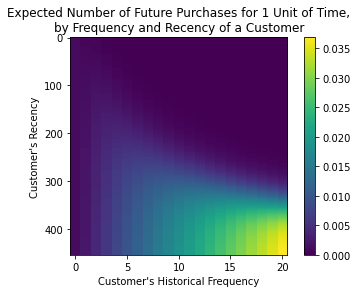

In [172]:
# Recency_Frequency Plot
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

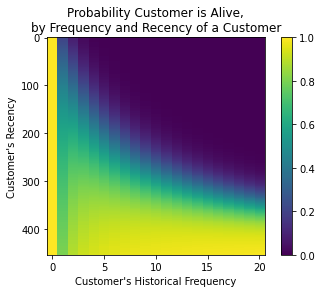

In [173]:
# Still alive plot
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

### Rank customer from Best to Worst

In [175]:
t = 1  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase', ascending=False).head(5)

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,9.021947e+05,0.036614
CONSUMIDOR FINAL FISICO,18.0,428.0,439.0,8.291984e+05,0.033935
BANCO POPULAR DOMINICANO,9.0,437.0,454.0,1.130681e+06,0.016772
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,3.287440e+06,0.015758
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,8.0,384.0,439.0,4.986207e+05,0.014827


In [176]:
t = 3  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase', ascending=False).head(5)

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,9.021947e+05,0.109788
CONSUMIDOR FINAL FISICO,18.0,428.0,439.0,8.291984e+05,0.101755
BANCO POPULAR DOMINICANO,9.0,437.0,454.0,1.130681e+06,0.050292
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,3.287440e+06,0.047241
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,8.0,384.0,439.0,4.986207e+05,0.044457


In [215]:
t = 30  #day(s)
xaction_RFM['predicted_purchase'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    xaction_RFM['frequency'], 
    xaction_RFM['recency'], 
    xaction_RFM['T']
)
xaction_RFM.sort_values(by='predicted_purchase', ascending=False).head(5)

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,9.021947e+05,1.097071
CONSUMIDOR FINAL FISICO,18.0,428.0,439.0,8.291984e+05,1.017923
BANCO POPULAR DOMINICANO,9.0,437.0,454.0,1.130681e+06,0.512510
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,3.287440e+06,0.487033
BANCO CENTRAL DE LA REPUBLICA DOMINICANA,8.0,384.0,439.0,4.986207e+05,0.467338


### Split Data (training & validation)

#### Calibration period histogram

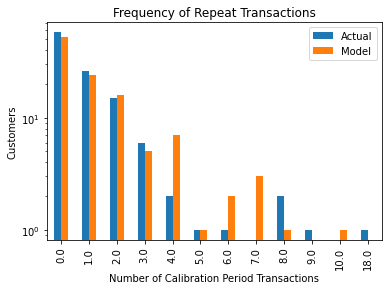

In [179]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf, max_frequency=10).set_yscale('log')

#### Cumulative transaction plot

In [186]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(
    df,
    'Cliente',
    'Fecha',
    calibration_period_end = (max(df['Fecha']) - datetime.timedelta(45)),
    observation_period_end = max(df['Fecha'])
)

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Cliente,,,,,
PRODUCTOS QUÍMICOS INDUSTRIALES,0.0,0.0,162.0,0.0,45.0
STRATEGY SOLUTIONS,0.0,0.0,212.0,0.0,45.0
Trailer Services SRL,0.0,0.0,136.0,0.0,45.0
ADMINISTRADORA DE RIESGOS DE SALUD DR YUNEN S A,0.0,0.0,274.0,0.0,45.0
AES ANDRES DR S A,2.0,358.0,360.0,0.0,45.0


In [187]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 113 subjects, a: 0.06, alpha: 109.48, b: 0.35, r: 0.74>

<AxesSubplot:title={'center':'Tracking Cumulative Transactions'}, xlabel='day', ylabel='Cumulative Transactions'>

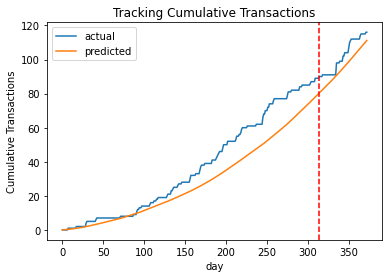

In [189]:
from lifetimes.plotting import plot_cumulative_transactions
plot_cumulative_transactions(bgf, df, 'Fecha', 'Cliente', 373, 313, freq='D')

#### Incremental transaction plot

<AxesSubplot:title={'center':'Tracking Daily Transactions'}, xlabel='day', ylabel='Transactions'>

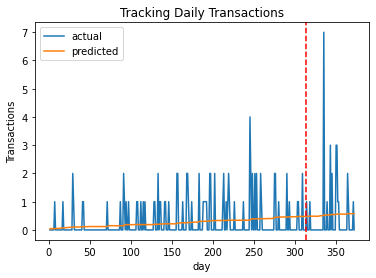

In [190]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(bgf, df, 'Fecha', 'Cliente', 373, 313, freq='D')

#### Conditional expectations plot

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

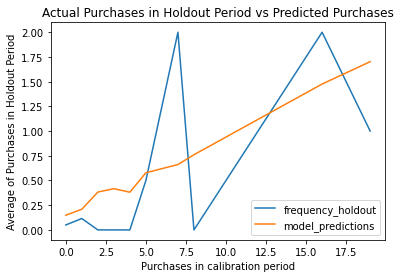

In [192]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=100)

### Predictions

#### Single Customer Prediction
Let's pick some customer and predict what that indivudla's future purchase might look like

In [195]:
t = 3  #predict purchases in 3-days
individual = xaction_RFM.loc['BANCO CENTRAL DE LA REPUBLICA DOMINICANA', :]    # customerID = '13694'
bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    individual['frequency'], 
    individual['recency'], 
    individual['T']
)

0.04681278145490199

#### Single Customer probability Histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model.

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

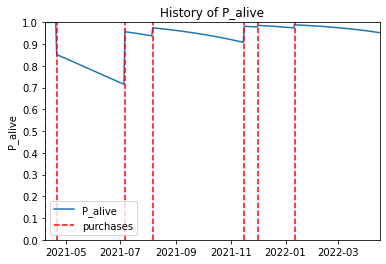

In [218]:
from lifetimes.plotting import plot_history_alive

# customer_ID = 'BANCO CENTRAL DE LA REPUBLICA DOMINICANA'
# customer_ID = 'EMBAJADA DE FRANCIA'
customer_ID = 'ASOCIACION CIBAO DE AHORROS Y PRESTAMOS'




days_since_birth = 373
sp_trans = df.loc[df['Cliente'] == customer_ID]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Fecha')

## Estimating CLV using Gamma-Gamma model
Until now, we have not taken into account the economics value of each transaction; rather, we've only been focusing on transactions' occurences.

In order to estimate CLV, we will use the Gamma-Gama submodel.

First, we shall create summary data from the transactional data that contains the economics values for each transaction (e.g., profits or revenues).

In [209]:
summary_with_money_value = xaction_RFM
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value'] > 0]
returning_customers_summary.head()

,frequency,recency,T,monetary_value,predicted_purchase
Cliente,,,,,
AES ANDRES DR S A,2.0,358.0,405.0,5.242816e+05,0.013442
APP QUISQUEYA SRL,2.0,49.0,75.0,2.301340e+06,0.037974
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS,6.0,278.0,298.0,3.287440e+06,0.047241
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS,20.0,443.0,454.0,9.021947e+05,0.109788
BANCO CARIBE,1.0,21.0,74.0,1.602900e+05,0.019505


### Gamma-Gamma Model && Independence Assumptions
The model we are going to use to estimate the CLV for our data is called the Gamma-Gamma submodel, which relies upon an important assumption.

The Gamma-Gamma submodel assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [210]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.148144
frequency,0.148144,1.000000


### Train Gamma-Gamma model

In [212]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
)
ggf

<lifetimes.GammaGammaFitter: fitted with 53 subjects, p: 0.47, q: 1.77, v: 1363748.50>

### Est. Avg. Transaction Value

In [213]:
ggf.conditional_expected_average_profit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value']
).head(11)

Cliente
AES ANDRES DR S A                                     6.652745e+05
APP QUISQUEYA SRL                                     1.645440e+06
ASOCIACION CIBAO DE AHORROS Y PRESTAMOS               2.765313e+06
ASOCIACION POPULAR DE AHORROS Y PRESTAMOS             8.974201e+05
BANCO CARIBE                                          5.803563e+05
BANCO CENTRAL DE LA REPUBLICA DOMINICANA              5.560661e+05
BANCO DE RESERVAS DE LA REPUBLICA DOMINICANA BANCO    8.422751e+05
BANCO MULTIPLE BHD LEON SA                            8.028225e+05
BANCO MULTIPLE BHD LEÓN S.A.                          5.243434e+05
BANCO POPULAR DOMINICANO                              1.086000e+06
BARNA MANAGEMENT SCHOOl                               5.386458e+05
dtype: float64

In [214]:
print(
    "Expected conditional average revenue: %s, Average revenue: %s" % (
        ggf.conditional_expected_average_profit(
            returning_customers_summary['frequency'],
            returning_customers_summary['monetary_value']
        ).mean(),

        summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
    )
)

Expected conditional average revenue: 794883.6058525793, Average revenue: 607937.3822083086
